# STA 141B Project Group 12

## Introduction

The main point of this project will be to see what factors affect a game's ratings or "how good" a game is. Some possible factors include price, popularity / culture, gameplay, etc...
#Later specify which factors in specific
#Should also specify the broader significance and impact of this question

## Methods

In [1]:
import requests
import pandas as pd
import requests_cache
import time
requests_cache.install_cache("Final_Project")

In [2]:
url = 'https://www.cheapshark.com/api/1.0/deals' # Testing environment

result = requests.get(url, params= {
    'storeID' : 1,
    'AAA' : 1,
    'steamAppID' : 168162
})


In [7]:
test_set = pd.DataFrame()
for i in range(1, 2):
    result = requests.get(url, params= {
    'storeID' : 1,
    'pageNumber' : i,
    'AAA' : 1
    })

    data = result.json()
    data = pd.DataFrame(data)

    test_set = pd.concat([test_set, data], ignore_index=True)

    time.sleep(2)

remove later (rel code below)

In [8]:
full_set = pd.DataFrame()
for i in range(1, 51):
    result = requests.get(url, params= {
    'storeID' : 1,
    'pageNumber' : i
    })

    data = result.json()
    data = pd.DataFrame(data)

    full_set = pd.concat([full_set, data], ignore_index=True)

    time.sleep(2)

full_set = full_set[["title", "gameID", "releaseDate", "normalPrice", "metacriticScore", "steamRatingText", "steamRatingPercent"]]

In [3]:
aaa_set = pd.DataFrame()
for i in range(1, 46): # Putting in AAA parameter limits the max pages down to 50 for some reason
    result = requests.get(url, params= {
    'storeID' : 1,
    'pageNumber' : i,
    'AAA' : 1
    })

    data = result.json()
    data = pd.DataFrame(data)

    aaa_set = pd.concat([aaa_set, data], ignore_index=True)

    time.sleep(2)

aaa_set = aaa_set[["title", "gameID", "releaseDate", "normalPrice", "metacriticScore", "steamRatingText", "steamRatingPercent"]]

In [9]:
aaa_set["normalPrice"] = aaa_set["normalPrice"].astype(float)
aaa_set["metacriticScore"] = aaa_set["metacriticScore"].astype(int)
aaa_set["steamRatingPercent"] = aaa_set["steamRatingPercent"].astype(int)
aaa_set = aaa_set[aaa_set["metacriticScore"] > 0]
aaa_set = aaa_set[aaa_set["normalPrice"] < 70] # API has some errors address this in markdown

In [13]:
# testing environment

In [10]:
full_set["normalPrice"] = full_set["normalPrice"].astype(float)
full_set["metacriticScore"] = full_set["metacriticScore"].astype(int)
full_set["steamRatingPercent"] = full_set["steamRatingPercent"].astype(int)
type(full_set["normalPrice"][1])

numpy.float64

In [11]:
#aaa_set = full_set[full_set["normalPrice"] >= 29]
indie_set = full_set[full_set["normalPrice"] < 29] # No way to parse for normal price on the API, alternative method is this
indie_set = indie_set[indie_set["metacriticScore"] > 0] # To account for missing metacritic

### JUDAH SECTION

#### Conversion of datetime from unix to YY-MM-DD

In [14]:
full_set['releaseDate'] = pd.to_datetime(full_set['releaseDate'], unit='s').dt.date
aaa_set['releaseDate'] = pd.to_datetime(aaa_set['releaseDate'], unit='s').dt.date
indie_set['releaseDate'] = pd.to_datetime(indie_set['releaseDate'], unit='s').dt.date

In [12]:
full_set.head()

,title,gameID,releaseDate,normalPrice,metacriticScore,steamRatingText,steamRatingPercent
0,Stealth Bastard Deluxe,93923,2012-11-28,9.99,80,Very Positive,88
1,Prince of Persia: The Sands of Time,278,2003-12-02,9.99,89,Very Positive,85
2,Raw Data,154911,2017-10-02,39.99,87,Very Positive,82
3,GUILTY GEAR Xrd -SIGN-,147415,2015-12-09,29.99,84,Very Positive,91
4,BioShock Infinite,93503,2013-03-25,29.99,94,Very Positive,93


In [13]:
aaa_set.head()

,title,gameID,releaseDate,normalPrice,metacriticScore,steamRatingText,steamRatingPercent
0,Rise of the Tomb Raider,145517,2016-01-28,29.99,86,Very Positive,94
1,GOD EATER 2 Rage Burst,155097,2016-08-29,49.99,73,Very Positive,80
2,Yooka-Laylee,164041,2017-04-05,49.99,73,Mostly Positive,78
3,Dragons Dogma: Dark Arisen,146236,2016-01-15,29.99,81,Very Positive,89
4,The Sinking City,201604,2019-06-27,39.99,71,Mostly Positive,73


In [14]:
indie_set.head()

,title,gameID,releaseDate,normalPrice,metacriticScore,steamRatingText,steamRatingPercent
0,Stealth Bastard Deluxe,93923,2012-11-28,9.99,80,Very Positive,88
1,Prince of Persia: The Sands of Time,278,2003-12-02,9.99,89,Very Positive,85
6,Crayon Physics Deluxe,709,2009-01-07,19.99,79,Very Positive,90
7,Amnesia: The Dark Descent,86,2010-09-08,19.99,85,Overwhelmingly Positive,95
8,Company of Heroes,117,2006-09-13,19.99,93,Very Positive,94


#### Plots

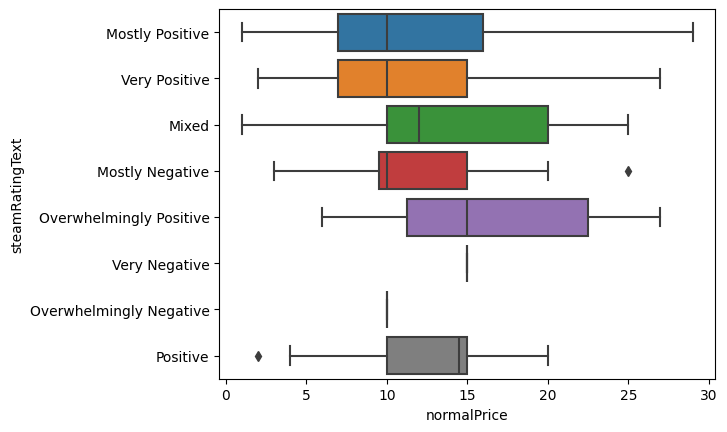

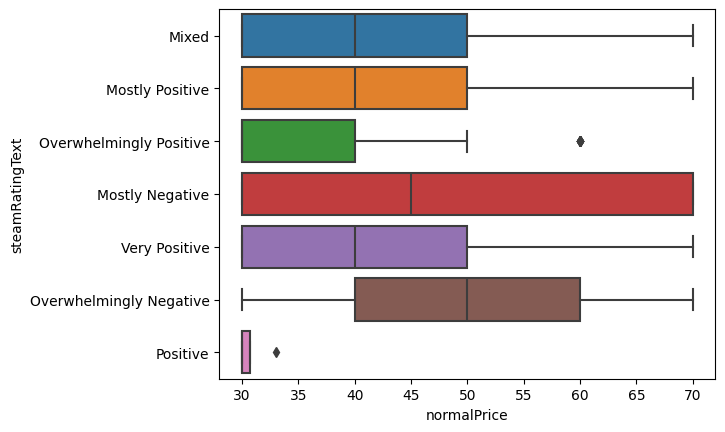

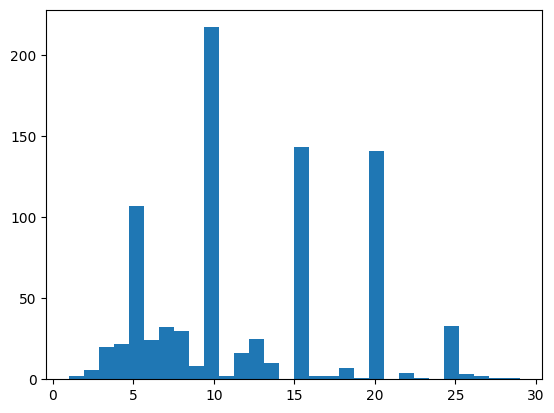

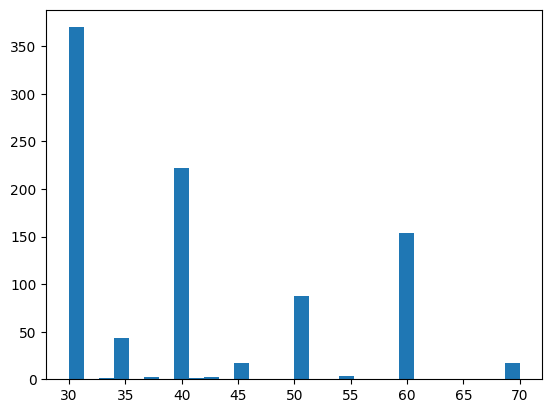

In [15]:
#Currently how it goes is :
#Check steamRatingText against price

#MAKE NOTES ON WHAT EACH PLOT MEANS, maybe make a time series or heatmap for dates etc
#ALSO put the plots on the same grid to make them easily comparable. or put them on the same graph with different colors
#In this one, it's lowk opposite of Shizhe chen. they're grading based on complexity.
#we need more dimensions for complexity

#Currently I'm checking
# - steamratingpercent/metacriticscore against normal price (via boxplots, histogrmas)
# - steamratingpercent/metacriticscore against release data
# - normalPrice against release date... inflation?
#so we're checking generally what factors affect a game's rating. the issue is this doesn't provide much factors except for the normalprice
#Can use youtube to check popularity
import matplotlib.pyplot as plt
import seaborn as sns

#Basic boxplot: Rating texts on normal price, for indie
sns.boxplot(x='normalPrice', y='steamRatingText', data=indie_set)
plt.show()

#Basic boxplot: Rating texts on normal price, for aaa
sns.boxplot(x='normalPrice', y='steamRatingText', data=aaa_set)
plt.show()
#fix idk why  overwhelmingly negative and positive are merged

#Find also just overall distribution of prices... then maybe for boxplots do percents? Right because you see the reviews are mainly at 
#    $15 but maybe that's because you just have a lot of games at $15. In which case, you'd wanna keep that in mind. Idk if you can
#    make an edit that'd change things though... mainly for indie

#PUT MORE LABELS FOR HISTOGRAMS
plt.hist(indie_set['normalPrice'], bins=30)
plt.show()

plt.hist(aaa_set['normalPrice'], bins=30)
plt.show()

#SEGMENTED HISTOGRAM for prices and stuff

#Try your own natural language processing to check ratings
#Check youtube something, maybe it affects something
#For complexity, I also want to try web scraping 

Testing environment

In [2]:
#test = result.json()
#print(result.headers['X-Total-Page-Count']) # Important if we want to parse through all pages
#print(result.url)
#
#test = pd.DataFrame(test)
#
#header = result.headers

## Results

## Discussion

## Acknowledgements